In [26]:
import os
import math
import torch
from transformers import AutoTokenizer, CLIPTextModel
from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers.schedulers import DDPMScheduler
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
from peft import LoraConfig, get_peft_model

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from accelerate import Accelerator
# from torch.cuda.amp import autocast, GradScaler
from torch.amp import autocast, GradScaler

import torch.optim as optim
from diffusers.schedulers import DDPMScheduler
from accelerate import Accelerator
from tqdm.auto import tqdm

from torch.nn.functional import pad

# Tokenize and encode captions
tokenizer = pipe.tokenizer
text_encoder = pipe.text_encoder.to("cuda")  # Ensure text encoder is on GPU

In [2]:
class DefectDataset(Dataset):
    def __init__(self, image_dir, mask_dir, caption_file_dir, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.caption_file_dir = caption_file_dir
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        mask_name = image_name.split(".")  # Assuming mask has the same name
        mask_name = mask_name[0] + "_rbg_mask." + mask_name[1]
        caption_file_name = os.path.splitext(image_name)[0] + '.txt'

        image_path = os.path.join(self.image_dir, image_name)
        mask_path = os.path.join(self.mask_dir, mask_name)
        caption_path = os.path.join(self.caption_file_dir, caption_file_name)

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Single-channel mask
        with open(caption_path, "r") as f:
            caption = f.read().strip()

        # Apply transformations
        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask, caption

In [3]:

# Define your data directories
image_directory = '../dataset/bottle/image/'
mask_directory = '../dataset/bottle/rbg_mask/'
caption_directory = '../dataset/bottle/captions/'

# Define image transformations (resize, normalize)
# Define transformations for images
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalize for RGB images
    transforms.Lambda(lambda x: x.half())  # Cast to torch.float16
])

# Define transformations for masks
mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),  # Convert mask to tensor without normalization
    transforms.Lambda(lambda x: x.half())  # Cast to torch.float16

])

# Create the dataset
dataset = DefectDataset(image_directory, mask_directory, caption_directory, image_transform=image_transform, mask_transform=mask_transform)

In [4]:
# Example of accessing an item
image, mask, caption = dataset[0]
print(f"Image shape: {image.shape}, Mask shape: {mask.shape}, Caption: {caption}")

# You'll then need to create DataLoaders for training and validation
from torch.utils.data import DataLoader, random_split

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1)

Image shape: torch.Size([3, 256, 256]), Mask shape: torch.Size([1, 256, 256]), Caption: The image shows a top-down view of a bottle, looking from the bottle's neck towards the bottom, with a white background. The bottom right corner has a large breakage defect, shaped like a quarter of a ring, in black color.


In [5]:
def get_dataloader(image_directory, mask_directory, caption_directory, batch_size=2):

    dataset = DefectDataset(image_directory, mask_directory, caption_directory, image_transform=image_transform, mask_transform=mask_transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

In [6]:
accelerator = Accelerator()
dataloader = get_dataloader(image_directory, mask_directory, caption_directory)
dataloader = accelerator.prepare(dataloader)

In [7]:
dataloader

In [8]:
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe.text_encoder.to("cpu")  # Move text encoder to CPU
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.33.1",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "DPMSolverMultistepScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [9]:
# Apply LoRA
lora_config = LoraConfig(
    r=4,
    lora_alpha=8,
    target_modules=["to_q", "to_k", "to_v", "to_out.0"],
    lora_dropout=0.1,
    bias="none"
)
unwrapped_model = pipe.unet
lora_model = get_peft_model(unwrapped_model, lora_config)

# Optimizer and GradScaler
optimizer = optim.AdamW(lora_model.parameters(), lr=1e-4)
scaler = GradScaler()

In [10]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [21]:
noisy_latents.shape, timesteps.shape

(torch.Size([2, 4, 32, 32]), torch.Size([2]))

In [22]:
captions

("The image shows a top-down view of a bottle, looking from the bottle's neck towards the bottom, with a white background. The lower left corner has a small breakage defect, shaped like a small part of a ring, in black color.",
 "The image shows a top-down view of a bottle, looking from the bottle's neck towards the bottom, with a white background. The lower right corner has a large breakage defect, shaped like a small part of a ring, in black color.")

In [23]:
def preprocess_captions(captions, max_length=77):
    inputs = tokenizer(
        captions,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )
    input_ids = inputs.input_ids.to("cuda")
    attention_mask = inputs.attention_mask.to("cuda")
    
    # Encode captions into embeddings
    encoder_hidden_states = text_encoder(input_ids, attention_mask)[0]
    return encoder_hidden_states

In [28]:
accumulation_steps = 1  # Simulate a batch size of 4 * 4 = 16
for epoch in range(5):
    for batch in dataloader:
        optimizer.zero_grad()
        
        # Extract batch data
        images, masks, captions = batch #batch["image"], batch["mask"], batch["caption"]
        
        # Ensure inputs are in torch.float16 and moved to GPU
        images = images.half().to("cuda")
        masks = masks.half().to("cuda")
        
        # Encode images into latent space
        latents = pipe.vae.encode(images).latent_dist.sample()
        
        # Generate noise and noisy latents
        noise = torch.randn_like(latents)
        timesteps = torch.randint(0, pipe.scheduler.num_train_timesteps, (latents.shape[0],), device=latents.device).long()
        noisy_latents = pipe.scheduler.add_noise(latents, noise, timesteps)
        
        # Preprocess captions
        encoder_hidden_states = preprocess_captions(captions)
        
        # Predict noise
        output = lora_model(noisy_latents, timesteps, encoder_hidden_states=encoder_hidden_states)
        noise_pred = output[0]  # Adjust based on output structure
        
        # Compute loss
        loss = torch.nn.functional.mse_loss(noise_pred, noise)
        loss.backward()
        optimizer.step()
    
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 1.6318359375
Epoch 0, Loss: 1.05859375
Epoch 0, Loss: 0.94775390625
Epoch 0, Loss: 1.00390625
Epoch 0, Loss: 0.468994140625
Epoch 0, Loss: 0.73486328125
Epoch 0, Loss: 0.4365234375
Epoch 0, Loss: 0.88671875
Epoch 0, Loss: 0.94091796875
Epoch 0, Loss: 0.943359375
Epoch 0, Loss: 1.79296875
Epoch 0, Loss: 0.99755859375
Epoch 0, Loss: 1.9150390625
Epoch 0, Loss: 0.80419921875
Epoch 0, Loss: 1.21484375
Epoch 0, Loss: 0.841796875
Epoch 0, Loss: 1.3134765625
Epoch 0, Loss: 1.3681640625
Epoch 0, Loss: 1.021484375
Epoch 0, Loss: 0.5849609375
Epoch 0, Loss: 0.2279052734375
Epoch 0, Loss: 0.63232421875
Epoch 0, Loss: 0.71484375
Epoch 0, Loss: 0.623046875
Epoch 0, Loss: 1.6826171875
Epoch 0, Loss: 0.45263671875
Epoch 0, Loss: 0.369384765625
Epoch 0, Loss: 0.3203125
Epoch 0, Loss: 0.3603515625
Epoch 0, Loss: 0.6962890625
Epoch 0, Loss: 1.20703125
Epoch 0, Loss: 0.5849609375
Epoch 1, Loss: 0.87939453125
Epoch 1, Loss: 0.669921875
Epoch 1, Loss: 1.576171875
Epoch 1, Loss: 1.37109375
Ep

In [30]:
from peft import LoraConfig, get_peft_model

# Assuming `lora_model` is your fine-tuned model
output_dir = "../outputs/"
lora_model.save_pretrained(output_dir)
print(f"LoRA weights saved to {output_dir}")

LoRA weights saved to ../outputs/


In [31]:
# Save the full pipeline
pipeline_output_dir = "../pipeline-output"
pipe.save_pretrained(pipeline_output_dir)
print(f"Full pipeline saved to {pipeline_output_dir}")

Full pipeline saved to ../pipeline-output


# Inference

In [41]:
len(train_dataset), len(val_dataset)

(50, 13)

Generating image for prompt: The image shows a top-down view of a bottle, looking from the bottle's neck towards the bottom, with a white background. Inside the bottle, there is a circular black fabric contaminant. In the upper left corner, there is a small breakage defect, shaped like a small part of a ring, in black color.


C:\Users\adity\AppData\Local\Temp\ipykernel_396\1214246026.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Image saved as generated_image_0.png
Generating image for prompt: The image shows a top-down view of a bottle, looking from the bottle's neck towards the bottom, with a white background. The middle of the left half has a large breakage defect, shaped like a small part of a ring, with the middle in gold color and the sides in black color.


  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Image saved as generated_image_1.png
Generating image for prompt: The image shows a top-down view of a bottle, looking from the bottle's neck towards the bottom, with a white background. The lower right corner has a large breakage defect, shaped like a small part of a ring, in black color.


  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Image saved as generated_image_2.png
Generating image for prompt: The image shows a top-down view of a bottle, looking from the bottle's neck towards the bottom, with a white background. The upper half has a large breakage defect, shaped like half a ring, in black color.


  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Image saved as generated_image_3.png
Generating image for prompt: The image shows a top-down view of a bottle, looking from the bottle's neck towards the bottom, with a white background. The upper right corner has a large breakage defect, shaped like a quarter of a ring, in black color.


  0%|          | 0/20 [00:00<?, ?it/s]

Image saved as generated_image_4.png
Generating image for prompt: The image shows a top-down view of a bottle, looking from the bottle's neck towards the bottom, with a white background. The upper right corner has a large breakage defect, shaped like a small part of a ring, in black color.


  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Image saved as generated_image_5.png
Generating image for prompt: The image shows a top-down view of a bottle, looking from the bottle's neck towards the bottom, with a white background. The middle of the left half has a large breakage defect, shaped like a small part of a ring, in black color. The lower right corner has a small breakage defect, shaped like a short strip, in black color.


  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Image saved as generated_image_6.png
Generating image for prompt: The image shows a top-down view of a bottle, looking from the bottle's neck towards the bottom, with a white background. The lower left corner has a large breakage defect, shaped like a quarter of a ring, in black color.


  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Image saved as generated_image_7.png
Generating image for prompt: The image shows a top-down view of a bottle, looking from the bottle's neck towards the bottom, with a white background. The lower half has a large breakage defect, shaped like half a ring, in black color.


  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Image saved as generated_image_8.png
Generating image for prompt: The image shows a top-down view of a bottle, looking from the bottle's neck towards the bottom, with a white background. The upper left corner has a small breakage defect, shaped like a small part of a ring, in black color.


  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Image saved as generated_image_9.png
Generating image for prompt: The image shows a top-down view of a bottle, looking from the bottle's neck towards the bottom, with a white background. Inside the bottle, there is a circular black fabric contaminant.


  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Image saved as generated_image_10.png
Generating image for prompt: The image shows a top-down view of a bottle, looking from the bottle's neck towards the bottom, with a white background. The bottom right corner has a large breakage defect, shaped like a quarter of a ring, in black color.


  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Image saved as generated_image_11.png
Generating image for prompt: The image shows a top-down view of a bottle, looking from the bottle's neck towards the bottom, with a white background. The lower left corner has a small breakage defect, shaped like a small part of a ring, in black color.


  0%|          | 0/20 [00:00<?, ?it/s]

Image saved as generated_image_12.png


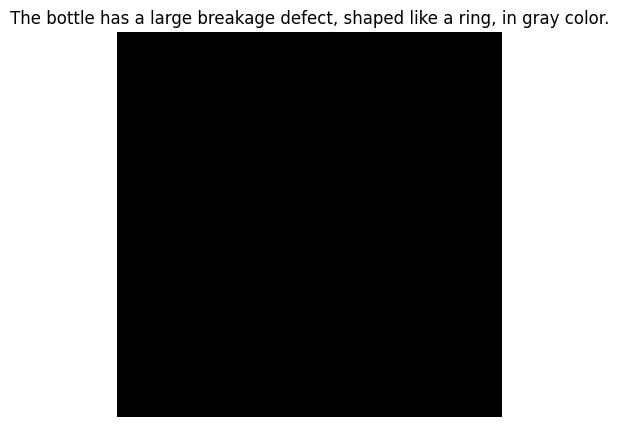

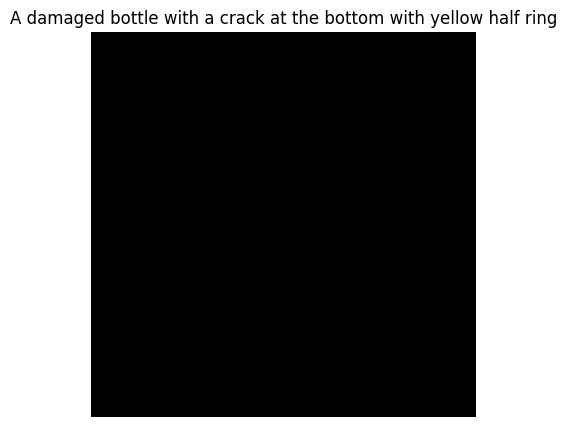

In [42]:
import os
import torch
from PIL import Image
import matplotlib.pyplot as plt
from diffusers import StableDiffusionPipeline
from peft import LoraConfig, get_peft_model

# # Load the pre-trained Stable Diffusion model
# model_id = "stabilityai/stable-diffusion-2"
# pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
# pipe.to("cuda")

# Apply LoRA configuration
# lora_config = LoraConfig(
#     r=8,
#     lora_alpha=32,
#     target_modules=["to_q", "to_k", "to_v", "to_out.0"],
#     lora_dropout=0.1,
#     bias="none"
# )
# unwrapped_model = pipe.unet
# lora_model = get_peft_model(unwrapped_model, lora_config)

# Load the fine-tuned weights
# lora_model.load_state_dict(torch.load("/path/to/fine_tuned_weights.pth"))

# Define the inference function
def generate_image(pipe, prompt, num_inference_steps=20, guidance_scale=10):
    negative_prompt = "image should not be dark and blurry."
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            image = pipe(prompt, negative_prompt = negative_prompt, num_inference_steps=num_inference_steps, guidance_scale=guidance_scale).images[0]
    return image

# Example prompts
# prompts = ["The bottle has a large breakage defect, shaped like a ring, in gray color.", "A damaged bottle with a crack at the bottom with yellow half ring", ]

# Generate and save images
for i in range(len(val_dataset)):
    prompt = val_dataset[i][2]
    print(f"Generating image for prompt: {prompt}")
    image = generate_image(pipe, prompt)
    image.save(f"generated_image_{i}.png")
    print(f"Image saved as generated_image_{i}.png")

# Display the generated images
for i in range(len(val_dataset)):
    prompt = val_dataset[i][2]
    
    image = Image.open(f"generated_image_{i}.png")
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.title(prompt)
    plt.axis("off")
    plt.show()